In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cmap
cm = cmap.inferno

import numpy as np
import scipy as sp
import theano
import theano.tensor as tt
import theano.tensor.nlinalg
import sys
import pymc3 as pm
import pandas as pd

In [6]:
df = pd.read_csv('embedding_vals.csv', index_col=0)
df

,years,Means 0,Means 1
0,2011,-2.295582,5.199455
1,2015,-3.292301,3.641375
2,2012,-3.173488,4.435188
3,2015,-5.078058,2.566646
4,2016,-4.605316,1.986195
5,2011,-2.223732,4.732081
6,2012,-3.173488,4.435188
7,2016,-4.903844,2.211651
8,2011,-2.806561,5.078961
9,2015,-3.292301,3.641375


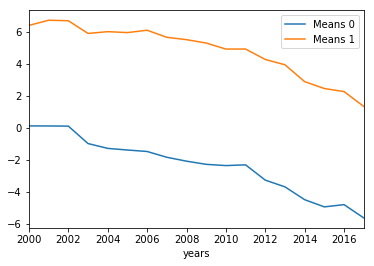

In [10]:
df.groupby('years').mean().plot()